# Support Vector Machines (SVM)

A *Support Vector Machine (SVM)* is capable of performing linear or non-linear classification, regression, and even outlier detection. SVMs are particularly well suited for classification of complex *small- or medium-sized datasets.*
<br>
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Linear SVM Classification

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1) # setosa = 0, versicolor = 1
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

Saving figure large_margin_classification_plot


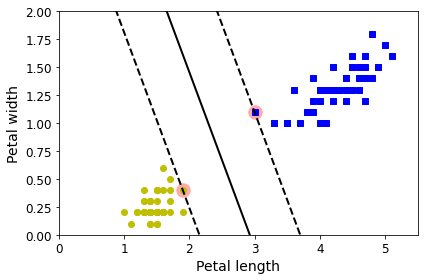

In [14]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):

    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    svs = svm_clf.support_vectors_
    
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

    
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.ylabel("Petal width", fontsize=14)
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plot_svc_decision_boundary(svm_clf, 0, 5.5)

save_fig("large_margin_classification_plot")
plt.show()